In [4]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_code import *
from classical_code import *
import stim
from tqdm import tqdm
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder

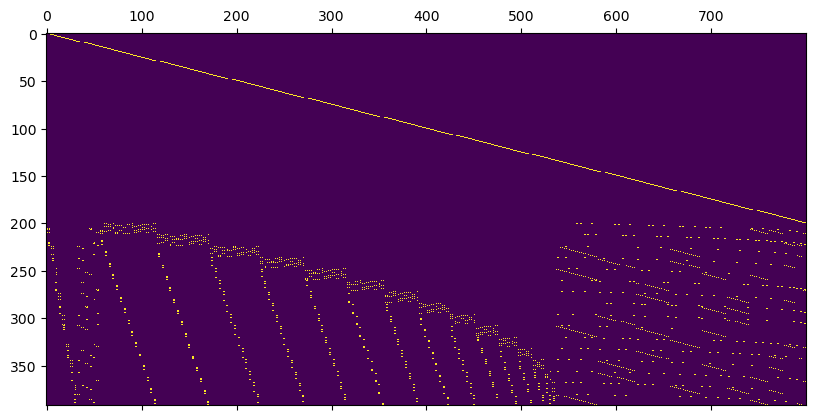

In [963]:
hgp_qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = hgp_qcode
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_400_8.qcode")


hgp_qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
qcode = hgp_qcode
qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# hgp_qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = hgp_qcode


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 4, "../codes/qcodes/")
# concatenate_steane(qcode, "../codes/qcodes/")


hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.001
meas_error_rate = 0.001

stab_type = False
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

# qed_dec_H = H[:qcode.qedxm]
# qed_channel_probs = [qubit_error_rate]*H.shape[1]

qec_aug_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
qec_aug_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])

qec_dec_H = hgp_H
qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(H)
# print(np.count_nonzero(Hx, axis=1))

In [964]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ
icebergX, icebergZ = iceberglogicals(4)

In [965]:
qec_aug_dec = BpDecoder(
    qec_aug_dec_H,
    channel_probs=qec_aug_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial"
    # osd_method="osd0",
    # osd_order=4 #the osd search depth
)

qec_dec = BpLsdDecoder(
    qec_dec_H,
    channel_probs=qec_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    lsd_method="lsd_cs",
    lsd_order=4 #the osd search depth
)

def decode(curr_synd, augment, concat):
    guessed_error = np.zeros(H.shape[1], dtype=int)

    if (concat == 0):
        # QEC only
        if augment:
            guessed_error ^= qec_aug_dec.decode(curr_synd[qcode.qedzm:])[:hgp_H.shape[1]]
        else:
            guessed_error ^= qec_dec.decode(curr_synd[qcode.qedzm:])
    elif (concat == 1):
        # QED + QEC
        curr_qed_synd = curr_synd[:qcode.qedxm]
        curr_hgp_synd = curr_synd[qcode.qedxm:]

        block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
        corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        guessed_error ^= corrections

        #######################
        new_channel_probs = 0.0003 * np.ones(hgp_H.shape[1])
        new_channel_probs[mapping[curr_qed_synd == 1].flatten()] = 0.5
        if augment:
            new_channel_probs = np.concatenate([new_channel_probs, [meas_error_rate]*hgp_H.shape[0]])
            qec_aug_dec.update_channel_probs(new_channel_probs)
        else:
            qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if augment:
            logical_correction = qec_aug_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]
        else:
            logical_correction = qec_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]

        physical_correction = np.zeros(Hx.shape[1], dtype=int)

        for c in np.where(logical_correction)[0]:
                iceberg_block = np.where(mapping == c)[0][0]
                iceberg_log = np.where(mapping == c)[1][0]
                if stab_type:
                        physical_correction[icebergZ[iceberg_log]+(4*iceberg_block)] ^= 1
                else:
                        physical_correction[icebergX[iceberg_log]+(4*iceberg_block)] ^= 1

        guessed_error ^= physical_correction
    return guessed_error

In [966]:
cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm
# qedm, qedn = concatenatedStabilizersQED.shape
# qecm, qecn = concatenatedStabilizersXQEC.shape
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cmx)
z_checks = np.arange(cn+cmx,cn+cmx+cmz)
all_qbts = np.arange(cn+cmx+cmz)

precomputed_x_checks_circuits = np.empty(cmx, dtype=object)
for x in np.arange(qcode.xm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    return c

precomputed_z_checks_circuits = np.empty(cmz, dtype=object)
for z in np.arange(qcode.zm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

In [967]:
class Simulation:
    def __init__(self, num_rounds, stab_type, concat=True, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.concat = concat
        self.adaptive = adaptive

        self.z_check_history = np.ones(cmz, dtype=int)
        self.x_check_history = np.ones(cmx, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+2, cmz), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+2, cmx), dtype=int)
        self.z_observables = np.zeros(qcode.k, dtype=int)
        self.x_observables = np.zeros(qcode.k, dtype=int)
        self.corrections = np.zeros(shape=(num_rounds+1, cn), dtype=int)

        self.c = stim.Circuit()
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cmz)).without_noise()
            for i, z_check in enumerate(np.arange(cmz)):
                self.c.append("MR", z_checks[z_check])
        else:
            self.c += prepare_x_checks(np.arange(cmx)).without_noise()
            for i, x_check in enumerate(np.arange(cmx)):
                self.c.append("MR", x_checks[x_check])

        self.s.do_circuit(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()


    def QED(self):
        def measure_z_qed_checks(c):
            c += prepare_z_checks(np.arange(qcode.qedzm))
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)
            c.append("MR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)])
            # if self.curr_round < self.num_rounds: c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)

            return c

        def measure_x_qed_checks(c):
            c += prepare_x_checks(np.arange(qcode.qedxm))
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)
            c.append("MR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)])
            # if self.curr_round < self.num_rounds: c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)

            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qed_checks(c)
            c = measure_z_qed_checks(c)
        else:
            c = measure_z_qed_checks(c)
            c = measure_x_qed_checks(c)
        return c

    def QEC(self):
        self.c.append("TICK")
        def measure_z_qec_checks(c, curr_z_checks):
            c += prepare_z_checks(curr_z_checks)
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)
            c.append("MR", [z_checks[z_check] for z_check in curr_z_checks])
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)

            return c

        def measure_x_qec_checks(c, curr_x_checks):
            c += prepare_x_checks(curr_x_checks)
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)
            c.append("MR", [x_checks[x_check] for x_check in curr_x_checks])
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)

            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qec_checks(c, self.curr_x_checks)
            c = measure_z_qec_checks(c, self.curr_z_checks)
        else:
            c = measure_z_qec_checks(c, self.curr_z_checks)
            c = measure_x_qec_checks(c, self.curr_x_checks)
        return c

    def final_synd_and_observables(self):
        c = stim.Circuit()

        if self.stab_type: self.c.append("H", [qbt for qbt in data_qbts])
        c.append("M", data_qbts)

        self.s.do_circuit(c)
        self.c += c

        meas = self.s.current_measurement_record()
        H = Hx if self.stab_type else Hz
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = np.array([j-cn for j in incl_qbts])

            if self.stab_type:
                self.x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

        for i, logical in enumerate(Lx if self.stab_type else Lz):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]

            if self.stab_type:
                self.x_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2

        if self.stab_type:
            final_correction = decode(self.x_syndrome_history[-1], 0, self.concat)
            self.x_observables ^= (Lx @ final_correction) % 2
        else:
            final_correction = decode(self.z_syndrome_history[-1], 0, self.concat)
            self.z_observables ^= (Lz @ final_correction) % 2



    def simulate(self):

        for _ in range(1, self.num_rounds+1):
            self.c.append("X_ERROR", data_qbts, qubit_error_rate)  # idle errors
            self.s.x_error(*data_qbts, p=qubit_error_rate)

            self.curr_z_checks = np.zeros(cmz)
            self.curr_x_checks = np.zeros(cmx)
            if not self.adaptive:
                self.curr_z_checks = np.arange(cmz)
                self.curr_x_checks = np.arange(cmx)
            else:
                QED_circuit = self.QED()
                self.s.do_circuit(QED_circuit)
                self.c += QED_circuit

                # determining which of the QEC stabilizers to measure
                meas = self.s.current_measurement_record()
                if self.stab_type:
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-(qcode.qedxm+qcode.qedzm):-qcode.qedxm]
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-qcode.qedzm:]

                    z_qed_synd_diff = self.z_syndrome_history[self.curr_round-1][:qcode.qedzm] ^ self.z_syndrome_history[self.curr_round][:qcode.qedzm]
                    self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
                    self.curr_x_checks = sorted(get_overlapping(self.x_syndrome_history[self.curr_round][:qcode.qedxm].copy(), True))
                else:
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-(qcode.qedzm+qcode.qedxm):-qcode.qedzm]
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-qcode.qedxm:]

                    x_qed_synd_diff = self.x_syndrome_history[self.curr_round-1][:qcode.qedxm] ^ self.x_syndrome_history[self.curr_round][:qcode.qedxm]
                    self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
                    self.curr_z_checks = sorted(get_overlapping(self.z_syndrome_history[self.curr_round][:qcode.qedzm].copy(), False))


            confirmation_z = np.concatenate([np.ones(qcode.qedzm, dtype=int), np.zeros(cmz-qcode.qedzm, dtype=int)])
            confirmation_z[self.curr_z_checks] = 1
            confirmation_x = np.concatenate([np.ones(qcode.qedxm, dtype=int), np.zeros(cmx-qcode.qedxm, dtype=int)])
            confirmation_x[self.curr_x_checks] = 1
            self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            lookback = lambda x: -len(x) if len(x) else None
            if self.stab_type:
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(np.concatenate([self.curr_x_checks, self.curr_z_checks])):
                                                                          lookback(self.curr_z_checks)]
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(self.curr_z_checks):]
            else:
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                          lookback(self.curr_x_checks)]
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(self.curr_x_checks):]

                guessed_error = decode(self.z_syndrome_history[self.curr_round], 1, self.concat)
                self.corrections[self.curr_round] = guessed_error
                self.s.x(*np.where(guessed_error)[0])

            self.curr_round += 1

        self.final_synd_and_observables()

In [968]:
concat = True if qcode.qedxm else False
adaptive = True if qcode.qedxm else False
# adaptive = False


num_iters = 100
num_rounds = 10
successes = 0
num_gens = []
for i in tqdm(range(num_iters)):
    s = Simulation(num_rounds, stab_type, concat=concat, adaptive=adaptive)
    s.simulate()
    c = s.c

    if np.any(s.z_observables):
        pass
    else:
        successes += 1

print(successes)

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]

99


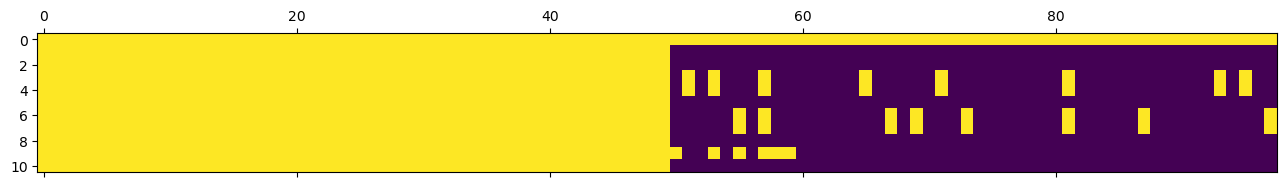

In [959]:
plt.matshow(s.z_check_history)

In [937]:
c

stim.Circuit('''
    H 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
    CX 200 0 200 1 200 2 200 3 201 4 201 5 201 6 201 7 202 8 202 9 202 10 202 11 203 12 203 13 203 14 203 15 204 16 204 17 204 18 204 19 205 20 205 21 205 22 205 23 206 24 206 25 206 26 206 27 207 28 207 29 207 30 207 31 208 32 208 33 208 34 208 35 209 36 209 37 209 38 209 39 210 40 210 41 210 42 210 43 211 44 211 45 211 46 211 47 212 48 212 49 212 50 212 51 213 52 213 53 213 54 213 55 214 56 214 57 214 58 214 59 215 60 215 61 215 62 215 63 216 64 216 65 216 66 216 67 217 68 217 69 217 70 217 71 218 72 218 73 218 74 218 75 219 76 219 77 219 78 219 79 220 80 220 81 220 82 220 83 

In [938]:
z_checks

array([298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
       311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 394, 395])